In [1]:
%load_ext autoreload
%autoreload 2

We need first install tensorflow_model_optimization, then needed tensorflow version, then tf_keras,  then needed tensorflow-io version   

tensorflow-addons ?

In [1]:
import tensorflow as tf

2024-07-26 22:42:51.665097: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 22:42:51.667933: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 22:42:51.676677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 22:42:51.691560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 22:42:51.695794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 22:42:51.706355: I tensorflow/core/platform/cpu_feature_gu

In [2]:
import tensorflow_model_optimization

In [3]:
# import tensorflow_io
from tensorflow_model_optimization.python.core.keras.compat import keras

In [3]:
from tensorflow_model_optimization.quantization import keras

In [10]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# from tensorflow_model_optimization.python.core.keras.compat import keras
import tensorflow_model_optimization as tfmot

sys.path.append("C:/Users/polin/TinyBirdSounds")

from create_spectrogram import create_spectrograms_from_audio_dataset
from helper_functions import (
    convert_bytes,
    convert_prefetchdataset_to_numpy_arrays,
    evaluate_time_of_prediction,
    get_file_size,
    predict_and_print_full_results,
)

In [11]:
train_dataset = tf.keras.utils.audio_dataset_from_directory(
    "../dataset/training",
    labels="inferred",
    sampling_rate=16000,
    batch_size=32,
    shuffle=True,
    seed=42,
)
test_dataset = tf.keras.utils.audio_dataset_from_directory(
    "../dataset/testing",
    labels="inferred",
    sampling_rate=16000,
    batch_size=32,
    shuffle=True,
    seed=42,
)
val_dataset = tf.keras.utils.audio_dataset_from_directory(
    "../dataset/validation",
    labels="inferred",
    sampling_rate=16000,
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 11292 files belonging to 2 classes.


2024-07-26 22:46:10.726604: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-07-26 22:46:10.730465: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


Found 1393 files belonging to 2 classes.
Found 1380 files belonging to 2 classes.


In [12]:
train_spectrogram_ds = (
    create_spectrograms_from_audio_dataset(train_dataset, sample_rate=16000)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)
test_spectrogram_ds = (
    create_spectrograms_from_audio_dataset(test_dataset, sample_rate=16000)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)
val_spectrogram_ds = (
    create_spectrograms_from_audio_dataset(val_dataset, sample_rate=16000)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

x_train_np, y_train_np = convert_prefetchdataset_to_numpy_arrays(train_spectrogram_ds)
x_val_np, y_val_np = convert_prefetchdataset_to_numpy_arrays(val_spectrogram_ds)
x_test_np, y_test_np = convert_prefetchdataset_to_numpy_arrays(test_spectrogram_ds)

2024-07-26 22:46:40.107074: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-26 22:46:43.495736: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


tf.Tensor([0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
0
tf.Tensor([1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0], shape=(32,), dtype=int32)
1


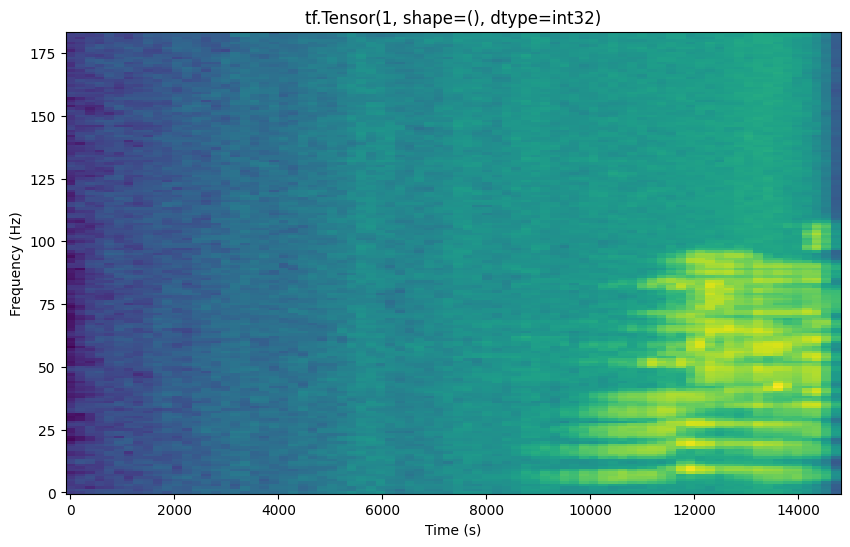

In [13]:
# non-target = 0, target = 1
# Print spectrograms of target or non-target class from dataset
class_number = 1

for i in train_spectrogram_ds:
    print(i[1])
    print(i[1][0].numpy())
    if i[1][0].numpy() == class_number:
        spectrogram = i[0][0]
        height = spectrogram.shape[0]
        width = spectrogram.shape[1]
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(X, Y, spectrogram)
        plt.title(i[1][0])
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.show()
        break

In [15]:
BASE_MODEL_FILE_NAME = (
    "../spectrogram_models_from_notebooks/cnn/hpo/cnn_mel_spec_baseline.keras"
)
base_model = tf.keras.models.load_model(BASE_MODEL_FILE_NAME)
base_model.summary()
convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "MB")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 182, 78, 4)        40        
                                                                 
 max_pooling2d (MaxPooling2  (None, 91, 39, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 89, 37, 4)         148       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 18, 4)         0         
 g2D)                                                            
                                                                 
 reshape (Reshape)           (None, 3168)              0         
                                                                 
 dense (Dense)               (None, 8)                 2

In [16]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(base_model)

# `quantize_model` requires a recompile.
q_aware_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 184, 80, 1)        3         
 yer)                                                            
                                                                 
 quant_conv2d (QuantizeWrap  (None, 182, 78, 4)        51        
 perV2)                                                          
                                                                 
 quant_max_pooling2d (Quant  (None, 91, 39, 4)         1         
 izeWrapperV2)                                                   
                                                                 
 quant_conv2d_1 (QuantizeWr  (None, 89, 37, 4)         159       
 apperV2)                                                        
                                                                 
 quant_max_pooling2d_1 (Qua  (None, 44, 18, 4)         1

In [17]:
q_aware_model.fit(
    x_train_np[:500], y_train_np[:500], batch_size=32, epochs=1, validation_split=0.1
)

/home/polina/newname/env_for_qat/lib/python3.9/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


15/15 [==============================] - 2s 52ms/step - loss: 0.1859 - accuracy: 0.9378 - val_loss: 0.0477 - val_accuracy: 1.0000


In [18]:
_, baseline_model_accuracy = base_model.evaluate(x_test_np, y_test_np, verbose=0)

_, q_aware_model_accuracy = q_aware_model.evaluate(x_test_np, y_test_np, verbose=0)

print("Baseline test accuracy:", baseline_model_accuracy)
print("Quant test accuracy:", q_aware_model_accuracy)

Baseline test accuracy: 0.9899497628211975
Quant test accuracy: 0.9597989916801453


In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpumko6fhs/assets


INFO:tensorflow:Assets written to: /tmp/tmpumko6fhs/assets
/home/polina/newname/env_for_qat/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1722026900.742888   24464 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1722026900.742951   24464 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-07-26 22:48:20.743359: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpumko6fhs
2024-07-26 22:48:20.747226: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-07-26 22:48:20.747267: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpumko6fhs
2024-07-26 22:48:20.763674: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-07-26 22:48:20.767221: I tenso

In [20]:
print("Validation dataset:")
(
    y_pred_val,
    non_overlap_patritions_f1_scores_val,
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(
    quantized_tflite_model, x_val_np, y_val_np, model_format="tf_lite"
)

print("\nTest dataset:")
(
    y_pred_test,
    non_overlap_patritions_f1_scores_test,
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(
    quantized_tflite_model, x_test_np, y_test_np, model_format="tf_lite"
)

Validation dataset:


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Basic assessment of the whole dataset (without any partitions):
Accuracy: 96.96%
Recall: 96.61%
Precision: 94.61%
F1-score: 95.60%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9555363922845688

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9542238282981039

Test dataset:
Basic assessment of the whole dataset (without any partitions):
Accuracy: 95.98%
Recall: 94.76%
Precision: 93.13%
F1-score: 93.94%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9388691658261668

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9352480878717273


In [21]:
print("For Test dataset:")
evaluate_time_of_prediction(
    quantized_tflite_model, x_test_np, y_test_np, model_format="tf_lite"
)

For Test dataset:
Accuracy: 95.98%
Recall: 94.76%
Precision: 93.13%
F1-score: 93.94%

Time to make a prediction for a single data point
Mean: 0.001 seconds
Max: 0.005 seconds
Min: 0.001 seconds


In [23]:
# Save model and print its size
QAT_MODEL_FILE_NAME = (
    "../spectrogram_models_from_notebooks/cnn/quantized/cnn_mel_speq_qat.tflite"
)
open(QAT_MODEL_FILE_NAME, "wb").write(quantized_tflite_model)
print("Model file name: ", QAT_MODEL_FILE_NAME)
convert_bytes(get_file_size(QAT_MODEL_FILE_NAME), "KB")

Model file name:  ../spectrogram_models_from_notebooks/cnn/quantized/cnn_mel_speq_qat.tflite
File size: 30.359 Kilobytes
